In [ ]:
!pip install pymoo

# Imports and setup
import openai
import numpy as np
import json
from itertools import permutations
import matplotlib.pyplot as plt
from pymoo.problems import get_problem

client = # insert your openai api key

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.1 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=7516f31b7ec128e3ad84f75d7d4aa75ff97a9bd0e31dab6f06caec1fc522b660
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


In [ ]:
problem = get_problem("zdt1")

def scalarized_objective(x, w1=0.5, w2=0.5):
    """
    Evaluate ZDT1 objectives and compute scalarized value.
    Args:
        x (np.ndarray): Decision variable vector.
        w1 (float): weight for first objective (f1)
        w2 (float): weight for second objective (f2)
    Returns:
        scalarized_value (float), f1 (float), f2 (float)
    """
    f = problem.evaluate(x.reshape(1, -1))
    f1, f2 = f[0]
    scalar_val = w1 * f1 + w2 * f2
    return scalar_val, f1, f2

# Example: random sample from decision space
x = np.random.rand(problem.n_var)  # decision variables in [0,1]

# Example weights (sum to 1)
w1, w2 = 0.3, 0.7

scalar_val, f1, f2 = scalarized_objective(x, w1, w2)
print(f"x: {x}")
print(f"f1: {f1:.4f}, f2: {f2:.4f}, scalarized: {scalar_val:.4f}")

x: [0.46957789 0.0274173  0.11133954 0.18801118 0.46325698 0.30096926
 0.1369762  0.79594561 0.46326807 0.4902924  0.88718742 0.91714019
 0.60183264 0.25544343 0.52878445 0.42232099 0.7440279  0.22070255
 0.3861761  0.67926571 0.32885292 0.97085532 0.7576344  0.36447137
 0.25678344 0.49976567 0.37400415 0.74357851 0.29109584 0.81990673]
f1: 0.4696, f2: 3.7678, scalarized: 2.7783


In [ ]:
import scipy

def objective_to_minimize(x, w1, w2):
    val, _, _ = scalarized_objective(x, w1, w2)
    return val

bounds = [(0, 1)] * problem.n_var  # variable bounds

res = scipy.optimize.minimize(objective_to_minimize, x0=np.random.rand(problem.n_var), args=(w1, w2),
               bounds=bounds, method='L-BFGS-B')

opt_x = res.x
opt_val, opt_f1, opt_f2 = scalarized_objective(opt_x, w1, w2)
print(f"Optimal x found: {opt_x}")
print(f"Optimal f1: {opt_f1:.4f}, f2: {opt_f2:.4f}, scalarized: {opt_val:.4f}")

Optimal x found: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Optimal f1: 1.0000, f2: 0.0000, scalarized: 0.3000


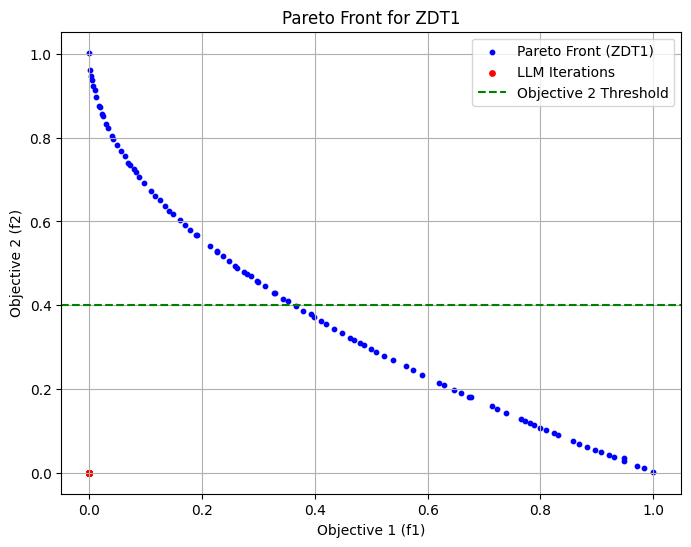

In [ ]:
# Get approximation for best solution from NSGA
valid_inds = np.where(F[:,1] < 0.4)[0]
f1_vals = F[valid_inds, 0]
min_f1_idx = valid_inds[np.argmin(f1_vals)]
best_sol = F[min_f1_idx]

print(f"Best solution found: {best_sol}")

# Get distance from LLM iterations and this optimal weight
distances = np.linalg.norm(opts_hist - best_sol, axis=1)
plt.plot(distances, 'r-x')
plt.xlabel('Iteration')
plt.ylabel('Distance to optimal solution')
plt.show()

NameError: name 'F' is not defined

In [ ]:
def run_llm_optimization(its=20, momentum=False):

  weight_hist = np.zeros((its+1,2))
  opts_hist   = np.zeros((its+1,2))

  # Initial prompt
  # initial_prompt = """
  # We are solving a multi-objective Optimization problem with two objectives.

  # We are more interested in minimizing the first objective than the second objective, however, we cannot tolerate
  # the second objective being over 0.4. Please help select weights to achieve this.

  # You will choose a pair of weights (minimize_distance, minimize_order_deviation) summing to 1.0, where:
  # - `w1` is the weight for the first objective (float between 0 and 1),
  # - `w2` is the weight for the second objective (float between 0 and 1).

  # Please return one weight pair in JSON format:
  # {"w1": <float>, "w2": <float>}

  # Please respond with only the JSON objective, no explanation, comments, or formatting.
  # """
  initial_prompt = """
  We are solving a multi-objective Optimization problem with two objectives.

  We care about twice as much about minimizing the first objective compared to the second objective. Please help select weights to reflect this preference.

  You will choose a pair of weights (minimize_distance, minimize_order_deviation) summing to 1.0, where:
  - `w1` is the weight for the first objective (float between 0 and 1),
  - `w2` is the weight for the second objective (float between 0 and 1).

  Please return one weight pair in JSON format:
  {"w1": <float>, "w2": <float>}

  Please respond with only the JSON objective, no explanation, comments, or formatting.
  """

  def ask_llm_for_weights(conversation_history):
      response = client.chat.completions.create(
          model="gpt-4",
          messages=conversation_history,
          temperature=0.7,
          max_tokens=100
      )
      return response.choices[0].message.content.strip()

  # Simulated initial state
  conversation = [{"role": "system", "content": "You are helping optimize a multi-objective optimization problem."},
                  {"role": "user", "content": initial_prompt}]

  # Ask for the first weights
  response = ask_llm_for_weights(conversation)
  conversation.append({"role": "assistant", "content": response})

  # Parse the response
  weights = json.loads(response)
  w1 = weights["w1"]
  w2 = weights["w2"]

  weight_hist[0] = [w1, w2]


  # print(f"Weights: w1={w1}, w2={w2}")

  # Run TSP solver (dummy function for illustration)
  bounds = [(0, 1)] * problem.n_var  # variable bounds

  res = scipy.optimize.minimize(objective_to_minimize, x0=np.random.rand(problem.n_var), args=(w1, w2),
                bounds=bounds, method='L-BFGS-B')

  opt_x = res.x
  opt_val, opt_f1, opt_f2 = scalarized_objective(opt_x, w1, w2)

  opts_hist[0] = [opt_f1, opt_f2]

  # print(f"opt_f1: {opt_f1}")
  # print(f"opt_f2: {opt_f2}")
  # Add feedback to LLM and iterate
  feedback_message = f"""
  You chose weights: {weights}.
  Results:
  - Total Distance: {opt_f1}
  - Priority Violations: {opt_f2}

  Suggest a new pair of weights to improve the balance.
  Respond only with JSON as before.
  """

  conversation.append({"role": "user", "content": feedback_message})

  # Repeat interaction
  for i in range(its):  # Iterate 3 times
      print(f"Iteration {i+1}")
      response = ask_llm_for_weights(conversation)
      conversation.append({"role": "assistant", "content": response})

      try:
          weights = json.loads(response)


          w1 = weights["w1"]
          w2 = weights["w2"]
          # print(f"Trying w1: {w1}")
          # print(f"w2: {w2}")

          if momentum and i > 1:
            w1 = 0.9 * w1 + 0.1 * weight_hist[i][0]
            w2 = 0.9 * w2 + 0.1 * weight_hist[i][1]

          weight_hist[i+1] = [w1, w2]
          bounds = [(0, 1)] * problem.n_var  # variable bounds

          res = scipy.optimize.minimize(objective_to_minimize, x0=np.random.rand(problem.n_var), args=(w1, w2),
                        bounds=bounds, method='L-BFGS-B')

          opt_x = res.x
          opt_val, opt_f1, opt_f2 = scalarized_objective(opt_x, w1, w2)
          opts_hist[i+1] = [opt_f1, opt_f2]
          # print(f"opt_f1: {opt_f1}")
          # print(f"opt_f2: {opt_f2}")

          # if np.linalg.norm(opts_hist[i+1] - opts_hist[i]) < 0.01:
          #   weight_hist = weight_hist[:i+1]
          #   opts_hist = opts_hist[:i+1]
          #   print("Stopping early")
          #   break

          feedback_message = f"""
          You chose weights: {weights}.
          Results:
          - Total Distance: {opt_f1}
          - Priority Violations: {opt_f2}

          Suggest a new pair of weights to improve the tradeoff. Reminder: we are more interested in minimizing the first objective than the second objective, however, we cannot tolerate
  the second objective being over 0.4. Please help select weights to achieve this.
          Respond only with JSON.
          """
          conversation.append({"role": "user", "content": feedback_message})

      except json.JSONDecodeError:
          print("Error parsing response:", response)
          break

  return weight_hist, opts_hist

In [ ]:
# Get a bunch of weights
m = 2
n = 20

all_weight_hist = np.zeros((m,n+1,2))
all_opts_hist = np.zeros((m,n+1,2))

for i in range(m):
  print(f"Run: {i}")
  weight_hist, opts_hist = run_llm_optimization(its=n)
  all_weight_hist[i] = weight_hist
  all_opts_hist[i] = opts_hist

# Get average over all runs
avg_weight_hist = np.mean(all_weight_hist, axis=0)
avg_opts_hist = np.mean(all_opts_hist, axis=0)
std_weight_hist = np.std(all_weight_hist, axis=0)
std_opts_hist = np.std(all_opts_hist, axis=0)

# Plot difference from best reference
distances = np.linalg.norm(avg_opts_hist - best_sol, axis=1)
distances_std = np.zeros(n+1)
for i in range(n+1):
  distances_std[i] = np.std(np.linalg.norm(all_opts_hist[:,i] - best_sol, axis=1))
#error bars
plt.errorbar(np.arange(n+1), distances, yerr=distances_std, fmt='o', label='95s% error bars')
plt.plot(distances, 'r-x', label='Distance from Optimal Solution')
plt.legend()
plt.title('Distance from Optimal Solution')
plt.xlabel('Iteration')
plt.ylabel('Distance')
plt.show()


Run: 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Run: 1
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20


NameError: name 'best_sol' is not defined

## Hidden Utility

Here I define a hidden negative utility function for a user and let the user give input after each generated solution. The user is happy if their negative utility function is within some tolerance of the optimal (set to be 0)

In [ ]:
# Get target weights
target_weights = [0.38, 0.62]

# scalarized solution with these weights
res = scipy.optimize.minimize(objective_to_minimize, x0=np.random.rand(problem.n_var), args=(target_weights[0], target_weights[1]),
              bounds=bounds, method='L-BFGS-B')
opt_x = res.x
opt_val, f1_star, f2_star = scalarized_objective(opt_x, target_weights[0], target_weights[1])

# negative utility function given the f1 and f2 values calculated
def user_neg_util(f1_star, f2_star, f1_val, f2_val):
  # print("Inside neg util")
  # print(f"f1_star: {f1_star}")
  # print(f"f2_star: {f2_star}")
  # print(f"f1_val: {f1_val}")
  # print(f"f2_val: {f2_val}")
  val1 = np.abs(f1_star - f1_val)
  val2 = np.abs(f2_star - f2_val)
  # print(f"val1: {val1}")
  # print(f"val2: {val2}")

  return val1 + val2

def get_user_input(f1_star, f2_star, tol, f1_val, f2_val, prev_score, not_first=True):
  score = user_neg_util(f1_star, f2_star, f1_val, f2_val)
  # print(f"Current score: {score}")
  # print(f"Previous score: {prev_score}")
  eval = ""
  done = False

  # The results are within the user's range of acceptable results
  if score <= tol:
    print(f"score: {score}")
    print(f"f1_star: {f1_star}")
    print(f"f2_star: {f2_star}")
    print(f"f1_val: {f1_val}")
    print(f"f2_val: {f2_val}")
    print(user_neg_util(f1_star, f2_star, f1_val, f2_val))
    eval += "I am happy with this result!"
    done = True

  # Let the LLM know whether or not they are getting warmer or colder
  # if not done and not_first:
  #   if score < prev_score:
  #     eval += " These results are better than your last output."
  #   else:
  #     eval += " These results are worse than your last output."

  # Let the user know in which direction you would like it to move
  if not done and f1_val < f1_star:
    eval += " I would like for the value of the first objective to increase. Therefore you should increase the weight for the second objective."
  else:
    eval += " I would like for the value of the first objective to decrease. Therefore you should increase the weight for the first objective."

  return eval, done, score

# function to plot region of acceptability




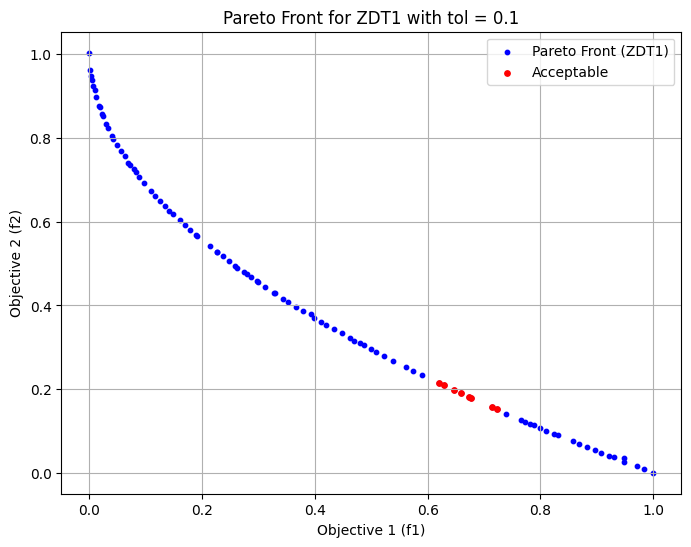

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.problems import get_problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# Load ZDT1 problem
problem = get_problem("zdt1")

# Define algorithm (NSGA-II)
algorithm = NSGA2(pop_size=100)

# Set termination condition
termination = get_termination("n_gen", 200)

# Run the multi-objective optimization
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=False,
               verbose=False)

# Extract the Pareto front
F = res.F  # shape (n_solutions, 2) -> f1, f2 values

# get values for which are in the tolerance
tol = 1e-1
neg_utils = user_neg_util(f1_star, f2_star, F[:,0], F[:,1])
valid_inds = np.where(neg_utils <= tol)[0]
F_valid = F[valid_inds]

# Take the

# Plot Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(F[:, 0], F[:, 1], color="blue", s=10, label="Pareto Front (ZDT1)")
plt.scatter(F_valid[:,0], F_valid[:,1], color="red", s=15, label="Acceptable")
plt.title(f"Pareto Front for ZDT1 with tol = {tol}")
plt.xlabel("Objective 1 (f1)")
plt.ylabel("Objective 2 (f2)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def run_convo_optimization(max_its = 30, tol = 1e-1, momentum=False):

  scores_hist = np.zeros(max_its+1)
  weight_hist = np.zeros((max_its+1,2))
  opts_hist   = np.zeros((max_its+1,2))


  # Initial prompt
  initial_prompt = """
  We are solving a multi-objective Optimization problem with two objectives.

  We are more interested in minimizing the second objective than the first objective. Please help select weights to achieve this.

  Note: When you suggest weights, do not only suggest ones which are even like (0.3,0.7) but also try different increments like (0.33,0.67) and other
  odd combinations. If the user says that you are getting closer to their objective it is usually wiser to change the weights more slowly as you approach their
  desired objective.

  You will choose a pair of weights (minimize_distance, minimize_order_deviation) summing to 1.0, where:
  - `w1` is the weight for the first objective (float between 0 and 1),
  - `w2` is the weight for the second objective (float between 0 and 1).

  Please return one weight pair in JSON format:
  {"w1": <float>, "w2": <float>}

  Please respond with only the JSON objective, no explanation, comments, or formatting.
  """
  # Note: Was previously using temperature set to 0.7
  def ask_llm_for_weights(conversation_history):
      response = client.chat.completions.create(
          model="gpt-4",
          messages=conversation_history,
          temperature=0.4,
          max_tokens=100
      )
      return response.choices[0].message.content.strip()

  # Simulated initial state
  conversation = [{"role": "system", "content": "You are helping optimize a multi-objective optimization problem."},
                  {"role": "user", "content": initial_prompt}]

  # Ask for the first weights
  response = ask_llm_for_weights(conversation)
  conversation.append({"role": "assistant", "content": response})

  # Parse the response
  weights = json.loads(response)
  w1 = weights["w1"]
  w2 = weights["w2"]

  weight_hist[0] = [w1, w2]


  # print(f"Weights: w1={w1}, w2={w2}")

  # Run TSP solver (dummy function for illustration)
  bounds = [(0, 1)] * problem.n_var  # variable bounds

  res = scipy.optimize.minimize(objective_to_minimize, x0=np.random.rand(problem.n_var), args=(w1, w2),
                bounds=bounds, method='L-BFGS-B')

  opt_x = res.x
  opt_val, opt_f1, opt_f2 = scalarized_objective(opt_x, w1, w2)

  opts_hist[0] = [opt_f1, opt_f2]

  # print(f"opt_f1: {opt_f1}")
  # print(f"opt_f2: {opt_f2}")
  # Add feedback to LLM and iterate
  feedback_message = f"""
  You chose weights: {weights}.
  Results:
  - Total Distance: {opt_f1}
  - Priority Violations: {opt_f2}
  """

  # Get User feedback
  eval, done, prev_score = get_user_input(f1_star, f2_star, tol, opt_f1, opt_f2, 0, not_first=False)
  scores_hist[0] = prev_score

  feedback_message += "User Evaluation: " + eval + "\n"

  feedback_message += "Suggest a new pair of weights to fulfill the user's request. Respond only with JSON as before."

  conversation.append({"role": "user", "content": feedback_message})

  if done:
    print(f"Finished after {0} iterations.")
    return w1,w2, opt_f1, opt_f2, weight_hist, opts_hist, scores_hist, 1

  # print(f"Iteration 0")
  # print(f"Current objective vals opt_f1: {opt_f1} and opt_f2: {opt_f2}")
  # print(f"User True Goal: f1_star: {f1_star} f2_star: {f2_star}")
  # print("Feedback:")
  # print(feedback_message)

  # Repeat interaction
  for i in range(max_its):  # Iterate 3 times
      print(f"Iteration {i+1}")
      response = ask_llm_for_weights(conversation)
      conversation.append({"role": "assistant", "content": response})

      try:
          weights = json.loads(response)


          w1 = weights["w1"]
          w2 = weights["w2"]
          # print(f"Trying w1: {w1}")
          # print(f"w2: {w2}")

          if momentum and i > 1:
            w1 = 0.9 * w1 + 0.1 * weight_hist[i][0]
            w2 = 0.9 * w2 + 0.1 * weight_hist[i][1]

          weight_hist[i+1] = [w1, w2]
          bounds = [(0, 1)] * problem.n_var  # variable bounds

          res = scipy.optimize.minimize(objective_to_minimize, x0=np.random.rand(problem.n_var), args=(w1, w2),
                        bounds=bounds, method='L-BFGS-B')

          opt_x = res.x
          opt_val, opt_f1, opt_f2 = scalarized_objective(opt_x, w1, w2)
          opts_hist[i+1] = [opt_f1, opt_f2]
          # print(f"opt_f1: {opt_f1}")
          # print(f"opt_f2: {opt_f2}")



          # Add feedback to LLM and iterate
          feedback_message = f"""
          You chose weights: {weights}.
          Results:
          - Total Distance: {opt_f1}
          - Priority Violations: {opt_f2}
          """

          # Get User feedback
          eval, done, prev_score = get_user_input(f1_star, f2_star, tol, opt_f1, opt_f2, prev_score)
          scores_hist[i+1] = prev_score

          feedback_message += "User Evaluation: " + eval + "\n"

          feedback_message += "Suggest a new pair of weights to fulfill the user's request. Respond only with JSON as before."

          conversation.append({"role": "user", "content": feedback_message})

          # print(f"Iteration {i+1}")
          # print(f"Current objective vals opt_f1: {opt_f1} and opt_f2: {opt_f2}")
          # print(f"User True Goal: f1_star: {f1_star} f2_star: {f2_star}")
          # print("Feedback:")
          # print(feedback_message)

          if done:
            print(f"Finished after {i+1} iterations.")
            return w1,w2, opt_f1, opt_f2, weight_hist, opts_hist, scores_hist, i+2

      except json.JSONDecodeError:
          print("Error parsing response:", response)
          break

  return w1,w2, opt_f1, opt_f2, weight_hist, opts_hist, scores_hist, max_its+1

In [ ]:
w1,w2, opt_f1, opt_f2, weight_hist, opts_hist, scores_hist, num_its = run_convo_optimization(max_its = 30, tol = 1e-1, momentum=False)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
score: 0.08761056061291261
f1_star: 0.665495101690652
f2_star: 0.18422116864271854
f1_val: 0.6116090161634075
f2_val: 0.21794564372838665
0.08761056061291261
Finished after 5 iterations.


0.38
0.62
0.66551275340532
0.18421034978045958
0.6654877986556551
0.18422564476709913
4.0249736304454053e-05


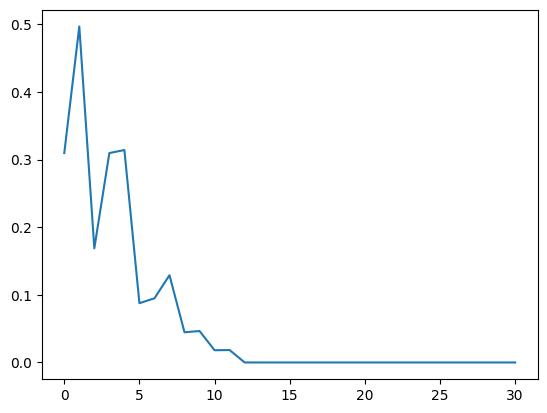

In [ ]:
print(w1)
print(w2)
print(opt_f1)
print(opt_f2)
print(f1_star)
print(f2_star)
print(np.abs(opt_f1 - f1_star) + np.abs(opt_f2 - f2_star))

plt.plot(scores_hist)
plt.show()

Run: 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
score: 2.8470576927008828e-05
f1_star: 0.665495101690652
f2_star: 0.18422116864271854
f1_val: 0.66551275340532
f2_val: 0.18421034978045958
2.8470576927008828e-05
Finished after 5 iterations.
Run: 1
Iteration 1
Iteration 2
score: 2.857621344032335e-05
f1_star: 0.665495101690652
f2_star: 0.18422116864271854
f1_val: 0.6655128188999643
f2_val: 0.18421030963859053
2.857621344032335e-05
Finished after 2 iterations.
Run: 2
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
score: 2.2552480605231295e-07
f1_star: 0.665495101690652
f2_star: 0.18422116864271854
f1_val: 0.6654952415153413
f2_val: 0.18422108294260187
2.2552480605231295e-07
Finished after 5 iterations.
Run: 3
Iteration 1
Iteration 2
Iteration 3
score: 0.09487603741981232
f1_star: 0.665495101690652
f2_star: 0.18422116864271854
f1_val: 0.724798805719017
f2_val: 0.14864883525127126
0.09487603741981232
Finished after 3 iterations.
Run: 4
Iteration 1
Iteration 2


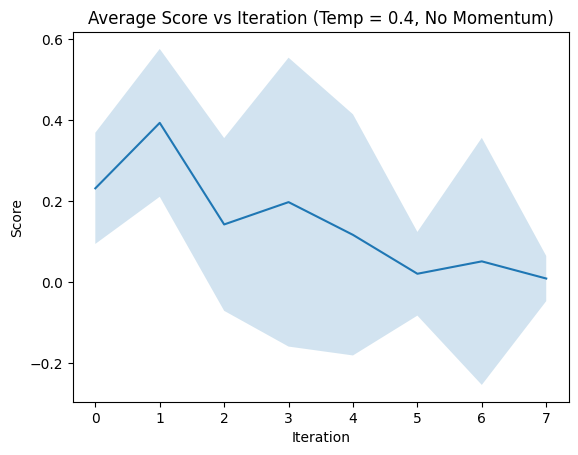

In [ ]:
## function to run test to get average convergence times

def run_test(runs, its, my_tol, mom=False):
  num_its_hist = np.zeros(runs)
  all_scores_hist = np.zeros((runs,its+1))


  for i in range(runs):
    print(f"Run: {i}")
    w1,w2, opt_f1, opt_f2, weight_hist, opts_hist, scores_hist, num_its = run_convo_optimization(max_its = its, tol = my_tol, momentum=mom)

    num_its_hist[i] = num_its
    all_scores_hist[i] = scores_hist

  return num_its_hist, all_scores_hist


num_its_hist, all_scores_hist = run_test(runs=20, its=30, my_tol=1e-1, mom=False)

print(f"Average Number of Iterations: {np.mean(num_its_hist)}")
print(f"Standard Deviation of Number of Iterations: {np.std(num_its_hist)}")

# Plot average scores vs iteration
avg_scores_hist = np.mean(all_scores_hist, axis=0)
std_scores_hist = np.std(all_scores_hist, axis=0)
max_its = int(np.max(num_its_hist))


plt.plot(avg_scores_hist[:max_its])
plt.fill_between(np.arange(max_its), avg_scores_hist[:max_its]-1.96*std_scores_hist[:max_its], avg_scores_hist[:max_its]+1.96*std_scores_hist[:max_its], alpha=0.2)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Average Score vs Iteration (Temp = 0.4, No Momentum)")
plt.show()


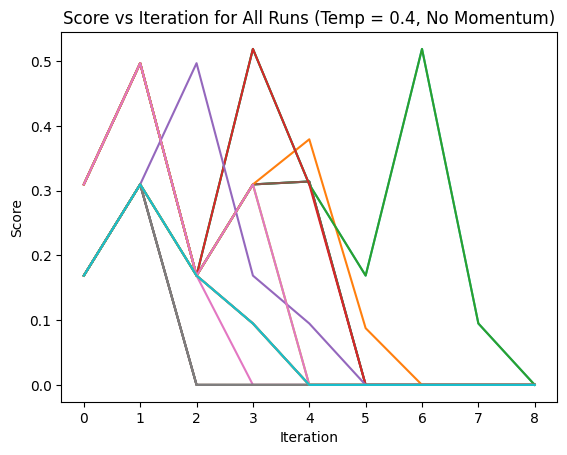

In [ ]:
#Plot all the iterations
for i in range(20):
  plt.plot(all_scores_hist[i,:max_its+1])

plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title(f"Score vs Iteration for All Runs (Temp = 0.4, No Momentum)")
plt.show()

In [ ]:
# Remove outliers
print(f"Average Number of Iterations: {np.mean(num_its_hist[num_its_hist <= 15])}")
print(f"Standard Deviation of Number of Iterations: {np.std(num_its_hist[num_its_hist <= 15])}")



Average Number of Iterations: 8.764705882352942
Standard Deviation of Number of Iterations: 3.4730798633236497
